In [1]:
import cv2
import numpy as np
import torch
import open_clip
from PIL import Image
import matplotlib.pyplot as plt

/Users/dasundealwis/Dossiers/forge doc identification/passport crop/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "ViT-B-32"
pretrained = "laion2b_s34b_b79k"   
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

model = model.to(device).eval()


In [3]:
PROMPTS = [
    "an open passport showing the identification page",
    "a passport data page with photo and text",
    "a passport biodata page",
    "a passport identity page",
    "a photo ID page in a passport",
]


In [4]:
def generate_windows_ar(H, W,
                        area_fracs=(0.45, 0.38, 0.32, 0.26, 0.22),
                        ratios=(1.25, 1.35, 1.45, 1.6, 1.0),
                        stride=0.22):
    """
    Windows by area fraction + aspect ratios.
    ratio = win_w / win_h
    """
    windows = []
    for a in area_fracs:
        for r in ratios:
            win_w = int(np.sqrt(a * W * H * r))
            win_h = int(np.sqrt(a * W * H / r))

            if win_w < 200 or win_h < 200 or win_w > W or win_h > H:
                continue

            sx = max(1, int(win_w * stride))
            sy = max(1, int(win_h * stride))

            for y0 in range(0, H - win_h + 1, sy):
                for x0 in range(0, W - win_w + 1, sx):
                    windows.append((x0, y0, x0 + win_w, y0 + win_h))
    return windows



In [ ]:
@torch.no_grad()
def clip_score_bgr(img_bgr, prompts):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)

    image = preprocess(pil).unsqueeze(0).to(device)
    text = tokenizer(prompts).to(device)

    image_feat = model.encode_image(image)
    text_feat  = model.encode_text(text)

    image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
    text_feat  = text_feat  / text_feat.norm(dim=-1, keepdim=True)

    sims = (image_feat @ text_feat.T).squeeze(0)  
    return float(sims.max().item())


In [6]:
def resize_keep_aspect(img, max_w=900):
    h, w = img.shape[:2]
    if w <= max_w:
        return img, 1.0
    scale = max_w / w
    new_size = (int(w * scale), int(h * scale))
    return cv2.resize(img, new_size, interpolation=cv2.INTER_AREA), scale


In [ ]:
def locate_data_page_zero_shot(img_bgr, prompts=PROMPTS, target_ratio=1.4):
    H, W = img_bgr.shape[:2]

    small, scale = resize_keep_aspect(img_bgr, max_w=900)
    Hs, Ws = small.shape[:2]

    windows = generate_windows_ar(Hs, Ws)

    if not windows:
        return img_bgr, {"reason": "no_windows_generated"}

    best = None
    for (x0, y0, x1, y1) in windows:
        crop = small[y0:y1, x0:x1]
        s = clip_score_bgr(crop, prompts)

        # penalties
        area = (x1-x0) * (y1-y0) / (Hs * Ws)
        r = (x1-x0) / ((y1-y0) + 1e-6)
        ar_pen = abs(np.log(r / target_ratio))          # 0 when perfect
        s_adj = s - 0.03 * area - 0.08 * ar_pen         

        if (best is None) or (s_adj > best["score_adj"]):
            best = {"x0":x0,"y0":y0,"x1":x1,"y1":y1,"score":s,"score_adj":s_adj,"area":area,"ratio":r}

    inv = 1.0 / scale
    x0 = int(best["x0"] * inv); y0 = int(best["y0"] * inv)
    x1 = int(best["x1"] * inv); y1 = int(best["y1"] * inv)

    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(W, x1); y1 = min(H, y1)

    crop_best = img_bgr[y0:y1, x0:x1].copy()

    debug = {
        "bbox": (x0, y0, x1, y1),
        "score": float(best["score"]),
        "score_adj": float(best["score_adj"]),
        "area_frac": float(best["area"]),
        "win_ratio": float(best["ratio"]),
        "num_windows": len(windows),
    }
    return crop_best, debug


In [8]:
def expand_bbox_asym(bbox, W, H,
                     pad_left=0.02, pad_right=0.55,
                     pad_top=0.00,  pad_bottom=2.10,
                     shift_x=0.02,  shift_y=0.48):
    """
    pad_* are fractions of bbox width/height.
    shift_* moves the box right/down by a fraction of bbox width/height.
    """
    x0, y0, x1, y1 = bbox
    bw = x1 - x0
    bh = y1 - y0

    # shift the bbox
    dx = int(shift_x * bw)
    dy = int(shift_y * bh)
    x0 += dx; x1 += dx
    y0 += dy; y1 += dy

    # asymmetric padding
    x0 = int(x0 - pad_left * bw)
    x1 = int(x1 + pad_right * bw)
    y0 = int(y0 - pad_top * bh)
    y1 = int(y1 + pad_bottom * bh)

    # clamp
    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(W, x1); y1 = min(H, y1)
    return (x0, y0, x1, y1)




In [9]:
def order_quad_points(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    return np.array([tl, tr, br, bl], dtype=np.float32)

def four_point_warp(image, quad, out_w=1000, out_h=700):
    quad = order_quad_points(quad)
    dst = np.array([
        [0, 0],
        [out_w - 1, 0],
        [out_w - 1, out_h - 1],
        [0, out_h - 1]
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(quad, dst)
    warped = cv2.warpPerspective(image, M, (out_w, out_h))
    return warped


In [10]:
def refine_to_page_boundary_threshold(crop_bgr):
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)

    # Normalize + smooth
    gray = cv2.bilateralFilter(gray, 9, 75, 75)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Invert so page content becomes foreground-ish
    thr = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 10
    )

    # Merge text blocks into one region (so the page becomes a big blob)
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8), iterations=2)
    thr = cv2.dilate(thr, np.ones((7,7), np.uint8), iterations=1)

    contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return crop_bgr, {"refine": "no_contours"}

    # Biggest contour as page candidate
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    H, W = crop_bgr.shape[:2]

    if area < 0.20 * (H * W):
        # If too small, likely grabbed just text area; return original crop
        return crop_bgr, {"refine": "contour_too_small", "area": float(area)}

    rect = cv2.minAreaRect(cnt)                 # ((cx,cy),(w,h),angle)
    box = cv2.boxPoints(rect).astype(np.float32)

    warped = four_point_warp(crop_bgr, box, out_w=1000, out_h=700)
    return warped, {"refine": "minAreaRect_warped", "area": float(area)}


In [11]:
def post_trim_warp(warped, trim_top=0.10, trim_bottom=0.00):
    h, w = warped.shape[:2]
    y0 = int(h * trim_top)
    y1 = int(h * (1.0 - trim_bottom))
    return warped[y0:y1, :]


Expanded bbox: (0, 1911, 2984, 4032)
Refine: {'refine': 'minAreaRect_warped', 'area': 2186002.5}


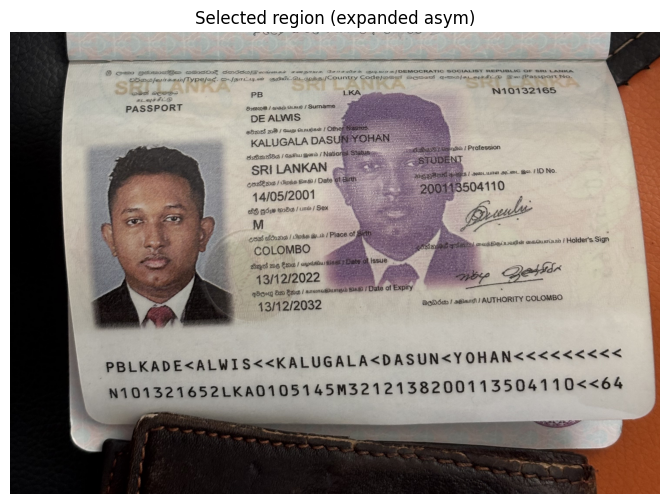

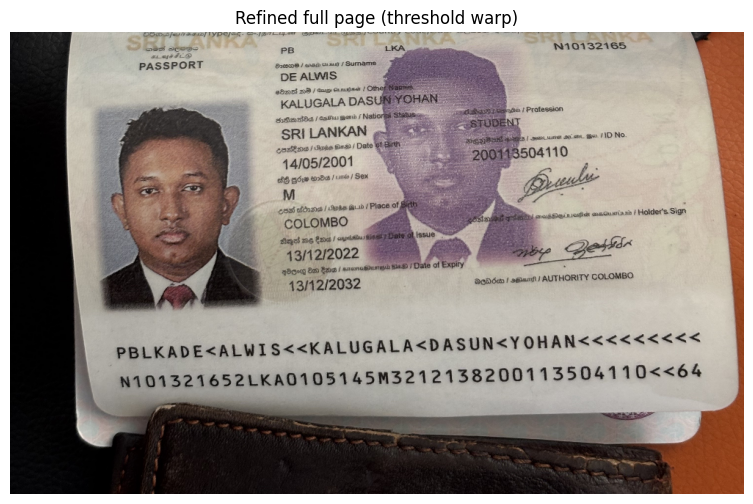

In [12]:
img = cv2.imread("IMG_1298.jpeg")
H, W = img.shape[:2]

region, dbg1 = locate_data_page_zero_shot(img)

bbox2 = expand_bbox_asym(
    dbg1["bbox"], W, H,
    pad_left=0.02, pad_right=0.55,
    pad_top=0.00,  pad_bottom=1.90,   # <-- increase this
    shift_x=0.02,  shift_y=0.48
)

x0,y0,x1,y1 = bbox2
region2 = img[y0:y1, x0:x1].copy()

page, dbg2 = refine_to_page_boundary_threshold(region2)

page = post_trim_warp(page, trim_top=0.10, trim_bottom=0.00)

print("Expanded bbox:", bbox2)
print("Refine:", dbg2)

 #notebook display (matplotlib)
import matplotlib.pyplot as plt
def show_bgr(bgr, title=""):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_bgr(region2, "Selected region (expanded asym)")
show_bgr(page, "Refined full page (threshold warp)")

